In [65]:
# Zachary Katz
# zachary_katz@mines.edu
# 5 May 2025

"""
Example notebook to load and plot Whillans station locations and 
Scripps grounding line.

Future: Plot on top of Mosaic of Antarctica and Antarctica ice velocity map

Revision History
v0.1 - 5 May 2025
    Basic plot
"""

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import shapefile
import cartopy
import cartopy.crs as ccrs

# Set path to stations and grounding line
sta_path = "../data/Stations.txt"
gl_path = "../data/scripps_polygons/scripps_antarctica_polygons_v1.shp"

In [76]:
# Load data
stas = pd.read_csv(sta_path, sep=" ")

sf = shapefile.Reader(gl_path)
fields = sf.fields[1:]  # Skip deletion flag
field_names = [field[0] for field in fields]

records = sf.records()
shapes = sf.shapes()

In [79]:
def plot_shapefile(
    records: list[shapefile._Record],
    shapes: list[shapefile.Shape],
    ax: cartopy.mpl.geoaxes.GeoAxes,
    colors: list[str],
) -> None:
    """
    Plots the given records and shapes on axis ax.

    Parameters
    ----------
    records : list[shapefile._Record]
        Shapely record containing shape classification
    shapes : list[shapefile.Shape]
        Shapely shape points
    ax : cartopy.mpl.geoaxes.GeoAxes
        Axes to polot on
    colors : list[str]
       [Grounded ice color, Ice Shelf color]; Must be length 2
    """
    for record, shape in zip(records, shapes):
        classification = record[field_names.index("Id_text")]
        points = shape.points
        parts = list(shape.parts)
        parts.append(
            len(points)
        )  # Append the end index of the last part of the shapefile
        for i in range(len(parts) - 1):
            part = points[parts[i] : parts[i + 1]]
            if (
                classification == "Isolated island"
                or classification == "Ice rise or connected island"
                or classification == "Grounded ice or land"
            ):
                ax.fill(*zip(*part), color=colors[0], linewidth=0.5, zorder=2)
            elif classification == "Ice shelf":
                ax.fill(*zip(*part), color=colors[1], linewidth=0.5, zorder=2)
            else:
                print(f"Unknown classification: {classification}")

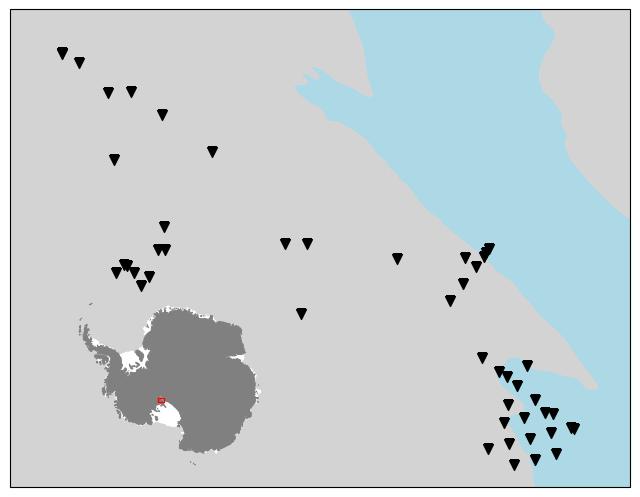

In [81]:
# Plot
ps71_projection = ccrs.Stereographic(
    central_latitude=-90, central_longitude=0, true_scale_latitude=-71
)
bbox = [-310000, -621000, -140000, -490000]  # Whillans bounding box, PS71
fig, ax = plt.subplots(subplot_kw={"projection": ps71_projection}, figsize=(8, 8))

# Filter records and shapes to bbox
filtered_records = []
filtered_shapes = []
for record, shape in zip(records, shapes):
    shape_bbox = shape.bbox
    # Checks if any part of the shape is within the bounding box
    if (
        shape_bbox[0] < bbox[2]
        and shape_bbox[2] > bbox[0]
        and shape_bbox[1] < bbox[3]
        and shape_bbox[3] > bbox[1]
    ):
        filtered_records.append(record)
        filtered_shapes.append(shape)

# Basemap
plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "lightblue"])

# Stations
ax.scatter(stas["X"], stas["Y"], marker="v", color="black", s=50, zorder=3)

ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

# Inset
inset = fig.add_axes(
    [0.2, 0.2, 0.25, 0.25], projection=ps71_projection
)  # [left, bottom, width, height]
inset.patch.set_facecolor("none")
for spine in inset.spines.values():
    spine.set_visible(False)
inset.set_xticks([])
inset.set_yticks([])

plot_shapefile(records, shapes, inset, ["gray", "white"])

rect = plt.Rectangle(
    (
        bbox[0],
        bbox[1],
    ),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    zorder=3,
    linewidth=1,
    edgecolor="red",
    facecolor="none",
)
inset.add_patch(rect)